In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from skimage import img_as_float, img_as_ubyte, io

In [48]:
# Set up matplotlib for inline plotting
%matplotlib inline

class MSRDatasetLoader:
    def __init__(self, root_dir, split_file):
        """
        Initialize MSR dataset loader
        
        Args:
            root_dir (str): Path to MSR dataset directory
            split_file (str): Path to split file (train.txt, test.txt, etc.)
        """
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        
        # Read split file
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
            
        print(f"Found {len(self.image_files)} images in the dataset")
    
    def load_image_pair(self, idx):
        """Load a pair of ground truth and input images"""
        filename = self.image_files[idx]
        
        # Load ground truth image
        gt_path = os.path.join(self.groundtruth_dir, filename)
        gt_img = cv2.imread(gt_path)
        b, g, r = cv2.split(gt_img)
        gt_img = cv2.merge([r, g, b])  # Convert to RGB
        
        # Load input image
        input_path = os.path.join(self.input_dir, filename)
        input_img = io.imread(input_path)
        
        return gt_img, input_img, filename
    
    def visualize_pair(self, idx):
        """Visualize a pair of ground truth and input images"""
        gt_img, input_img, filename = self.load_image_pair(idx)
        
        # Create mosaic visualization (normalized for display)
        input_viz = (input_img.astype(np.float32) / 65535 * 255).astype(np.uint8)
        
        # Create bilinear interpolation
        bilinear = cv2.cvtColor(input_viz, cv2.COLOR_BAYER_BG2RGB)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot images
        axes[0].imshow(gt_img)
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(input_viz, cmap='gray')
        axes[1].set_title('Raw Input (Bayer)')
        axes[1].axis('off')
        
        axes[2].imshow(bilinear)
        axes[2].set_title('Bilinear Demosaicing')
        axes[2].axis('off')
        
        plt.suptitle(f'Image: {filename}')
        plt.tight_layout()
        plt.show()
    
    def extract_patches(self, img, patch_size=33, stride=33):
        """Extract patches from an image"""
        patches = []
        h, w = img.shape[:2]
        
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                patch = img[i:i+patch_size, j:j+patch_size]
                patches.append(patch)
                
        return patches
    
    def visualize_patches(self, img_idx, patch_size=33, stride=33, max_patches=9):
        """Visualize patches extracted from an image"""
        gt_img, input_img, filename = self.load_image_pair(img_idx)
        
        # Extract patches
        gt_patches = self.extract_patches(gt_img, patch_size, stride)
        input_viz = (input_img.astype(np.float32) / 65535 * 255).astype(np.uint8)
        input_patches = self.extract_patches(input_viz, patch_size, stride)
        print(f"Patch_size: {gt_patches[0].shape}")

        
        # Limit number of patches to display
        n_patches = min(max_patches, len(gt_patches))
        
        # Create figure
        n_rows = int(np.ceil(n_patches / 3))
        fig, axes = plt.subplots(n_rows, 6, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        # Plot patches
        for i in range(n_patches):
            row = i // 3
            col = (i % 3) * 2
            
            # Plot ground truth patch
            axes[row, col].imshow(gt_patches[i])
            axes[row, col].set_title(f'GT Patch {i+1}')
            axes[row, col].axis('off')
            
            # Plot input patch
            axes[row, col+1].imshow(input_patches[i], cmap='gray')
            axes[row, col+1].set_title(f'Input Patch {i+1}')
            axes[row, col+1].axis('off')
        
        # Hide empty subplots
        for i in range(n_patches, n_rows*3):
            row = i // 3
            col = (i % 3) * 2
            axes[row, col].axis('off')
            axes[row, col+1].axis('off')
        
        plt.suptitle(f'Patches from {filename} (size={patch_size}x{patch_size}, stride={stride})')
        plt.tight_layout()
        plt.show()

In [49]:
# Example usage
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
split_file = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/test.txt'


In [50]:
# Create dataset loader
dataset = MSRDatasetLoader(dataset_path, split_file)

Found 200 images in the dataset


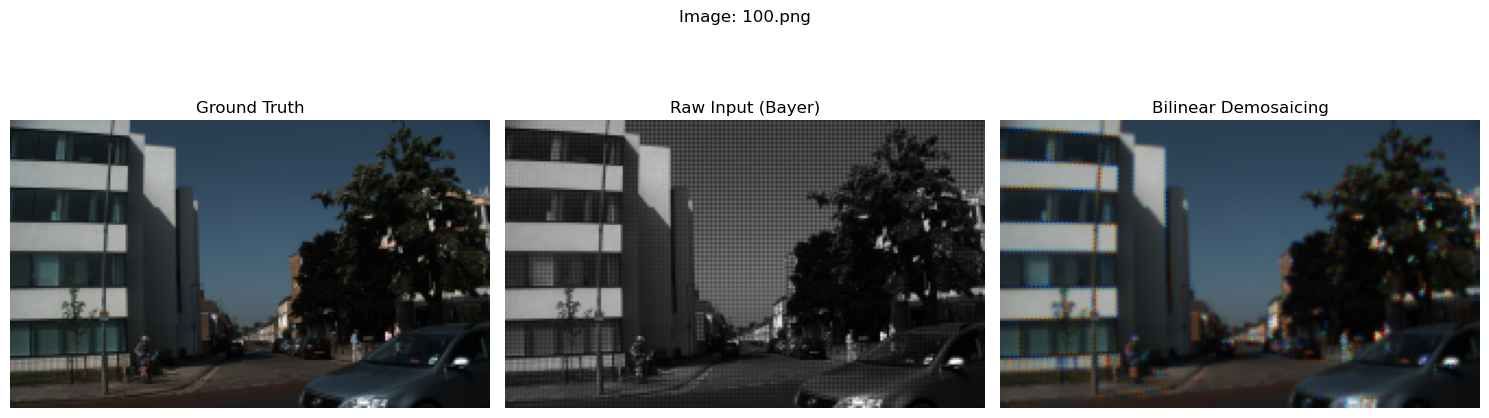

In [51]:
# Visualize first image pair
dataset.visualize_pair(0)

Patch_size: (33, 33, 3)


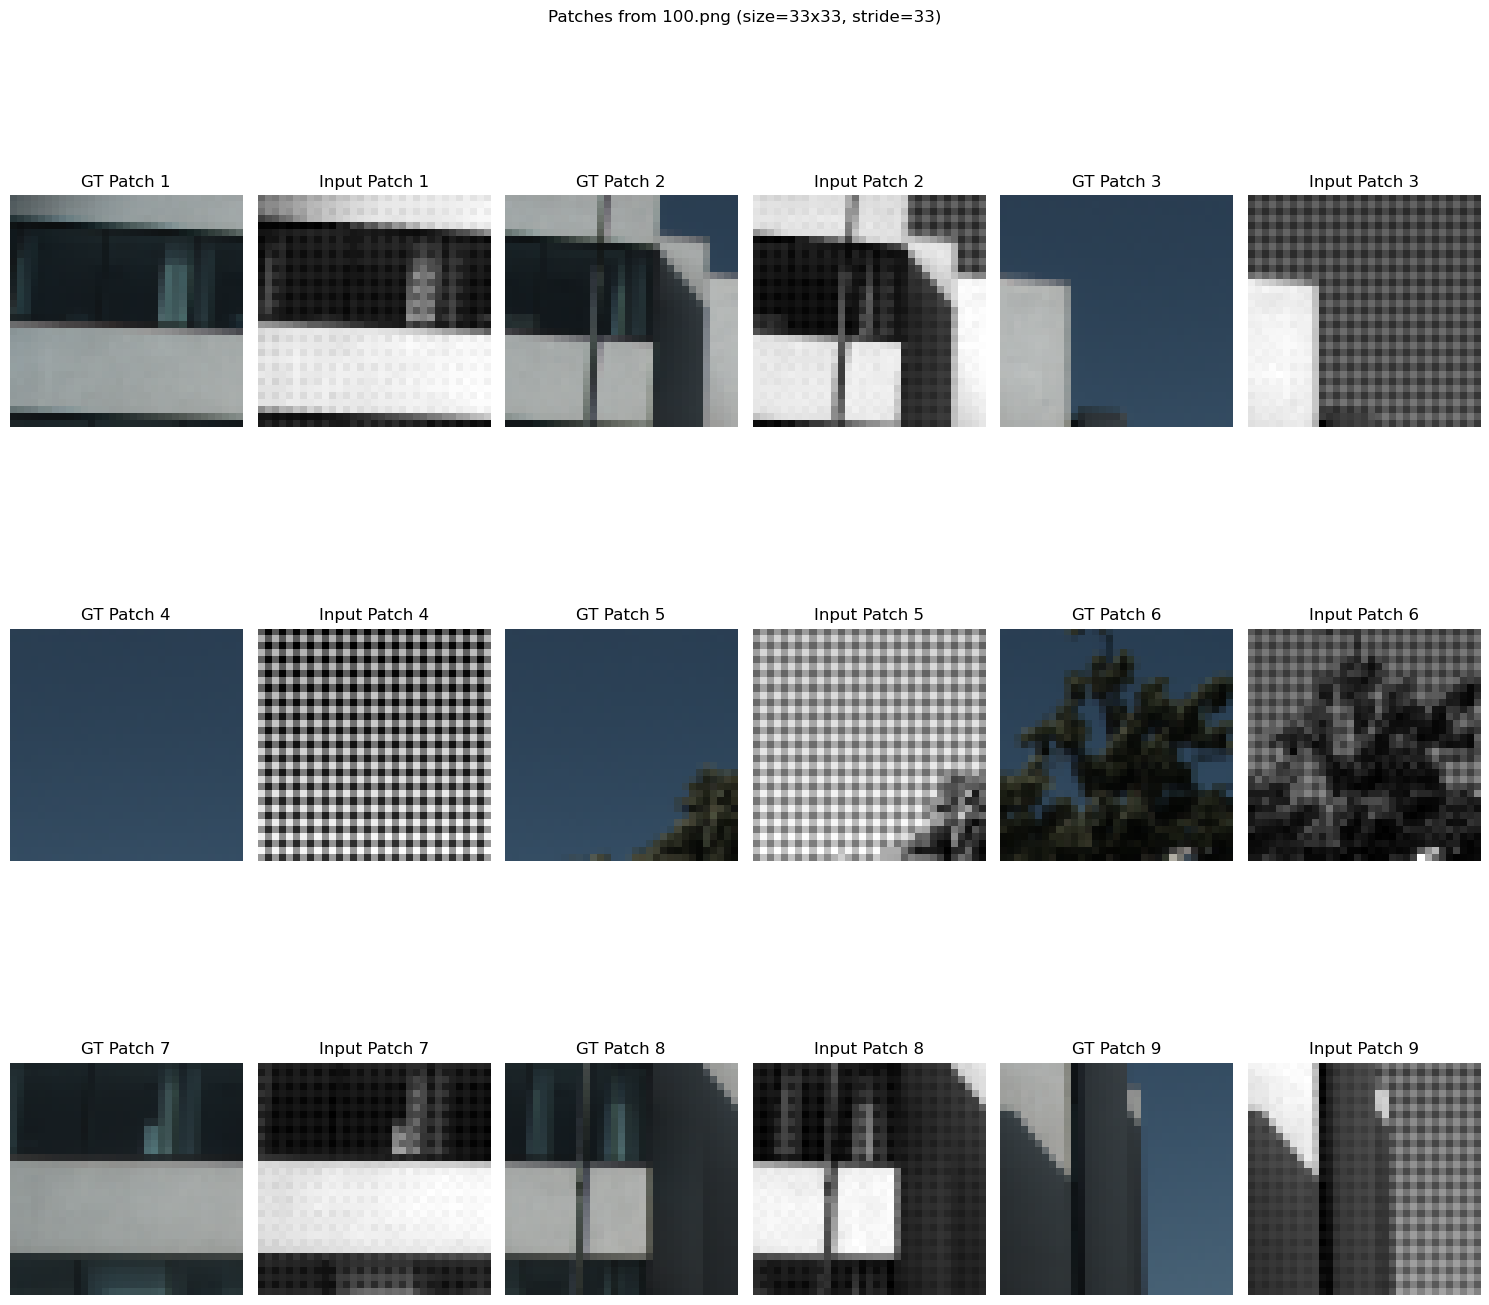

In [52]:
# Visualize patches from first image
dataset.visualize_patches(0, patch_size=33, stride=33, max_patches=9)

In [7]:
# Display dataset statistics
print("\nDataset Statistics:")
print("-" * 20)
print(f"Total images: {len(dataset.image_files)}")
print(f"Ground truth directory: {dataset.groundtruth_dir}")
print(f"Input directory: {dataset.input_dir}")



Dataset Statistics:
--------------------
Total images: 200
Ground truth directory: dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/groundtruth
Input directory: dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/input


In [8]:
# Example of accessing specific images
gt_img, input_img, filename = dataset.load_image_pair(0)
print(f"\nImage shapes:")
print(f"Ground truth: {gt_img.shape}")
print(f"Input: {input_img.shape}")


Image shapes:
Ground truth: (132, 220, 3)
Input: (132, 220)
